#### This notebook generates a set of features (financial indicators) that might be used as input data for the Reinforcement Learning model 

In [23]:
import pandas as pd
import numpy as np

import ffn.core as ffn   # provides probabilistic momentum operator: ffn.calc_prob_mom(.)
import bt

import matplotlib.pyplot as plt
plt.style.use('ggplot')
# plots of BT only work with this following command
%matplotlib inline

In [28]:
INPUT, OUTPUT = '../raw/raw_weekly_prices', '../silver/weekly_feature_set'
#INPUT, OUTPUT = '../raw/raw_daily_prices', '../silver/daily_feature_set'

In [29]:
df = pd.read_csv(INPUT+'.csv', parse_dates=True, index_col=0)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4972 entries, 2002-01-02 to 2021-09-30
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   XLK     4972 non-null   float64
 1   SPY     4972 non-null   float64
 2   TLT.O   4830 non-null   float64
 3   TAIL.K  1130 non-null   float64
 4   VIX     4972 non-null   float64
dtypes: float64(5)
memory usage: 233.1 KB


In [30]:
for index, row in df.iterrows():
    print(row.values)
    break

[ 24.6      115.53            nan        nan  22.709999]


In [31]:
df.loc[(~df['TLT.O'].isnull()) | (~df['TAIL.K'].isnull())]

,XLK,SPY,TLT.O,TAIL.K,VIX
2002-07-26,13.39,85.60,82.51,NaN,35.509998
2002-07-29,14.18,89.77,81.42,NaN,31.330000
2002-07-30,14.40,90.94,81.52,NaN,31.920000
2002-07-31,14.32,91.16,82.53,NaN,32.029999
2002-08-01,13.69,88.78,83.00,NaN,36.950001
...,...,...,...,...,...
2021-09-24,156.71,443.91,146.91,18.4900,17.750000
2021-09-27,155.19,442.64,146.37,18.4900,18.760000
2021-09-28,150.59,433.72,144.09,18.6500,23.250000
2021-09-29,150.40,434.45,144.34,18.6301,22.559999


---

#### Some useful functions for Feature Engineering

In [32]:
"""
Probabilistic momentum between returns series of two assets (ex. market x bonds) 
Probabilistic momentum can be defined as the probability or confidence that one asset (left) is going to outperform the other (right)
Params: 
    p_returns: dataframe of returns (pandas DataFrame)
    left_ticker: the name of the <TARGET> column at which the momentum is calculated
    right_ticker: the name of the <TARGET> column  at which the momentum is calculated
    lookback period: number of days (regular days, not business days)
    p_currentDate: reference date at which the momentum is calculated (pd.Datetime) 
    
Returns:
     mom: probabilistic momentum between left_ticker and right_ticker (ex. market x bonds) 
"""
def checkForProbMomentum(p_returns:pd.DataFrame, left_ticker: str, right_ticker: str, 
                         p_currentDate=pd.Timestamp, p_lookbackPeriod=66):
    
    v_startDate = p_currentDate - pd.DateOffset(days=p_lookbackPeriod)
    v_returns = p_returns.loc[ v_startDate:p_currentDate, [left_ticker,right_ticker] ]
        
    v_leftReturns = v_returns.iloc[:,0]
    v_rightReturns = v_returns.iloc[:,1]
        
    mom = ffn.calc_prob_mom(v_leftReturns, v_rightReturns)
     
    return mom    

"""
Rate of Change (ROC) with respect to Small and Large time windows  
Params: 
    data: pandas DataFrame
    windowSmallSize: size of "SMALL" time window
    windowLargeSize: size of "LARGE" time window
    t_col: the name of the <TARGET> column at which the rate of change is calculated
    
Returns:
     pSmall: rate of change with respect to the "SMALL" time window
     pLarge: rate of change with respect to the "LARGE" time window
     pInd: sum of pSmall and pLarge (aggregated rate of change)
"""

def rate_of_change(data:pd.DataFrame = None, t_col = '<CLOSE>', windowSmallSize:int = 13, windowLargeSize:int = 52):
    v_data = data[t_col].values
    dim = len(v_data)
    pSmall = np.full(dim,np.nan)
    pLarge = np.full(dim,np.nan)
    pInd = np.full(dim,np.nan)
    last_nan_index = sum(np.isnan(v_data))
    for t in range(last_nan_index,dim):
        vtemp = v_data[last_nan_index:t+1]
        windowSmall = vtemp[-windowSmallSize:]
        lowest = min(windowSmall)
        pSmall[t] = (vtemp[-1]/lowest - 1) * 100
        windowLarge = vtemp[-windowLargeSize:]
        largest = max(windowLarge)
        pLarge[t] = (vtemp[-1]/largest - 1) * 100
    
    pInd =  pSmall + pLarge
    
    return pInd, pSmall, pLarge

""" Slope (derivative) - similar to "momentum indicator" 
Params: 
    data: pandas DataFrame
    t_col: DataFrame column at which the first derivative is calculated   
    lag = lag for the difference operator
Returns:
     diff: pandas series
"""
def slope(data:pd.DataFrame = None, t_col = '<CLOSE>', lag:int = 3):
    diff =  data[t_col].diff(lag)
    return diff


In [7]:
# calculate probabilistic momentum between returns series of two assets (ex. market x bonds)
# probabilistic momentum definition:  “probability or confidence that one asset (left) is going to outperform the other (right)”.
# lookback period: n days (not business days)
# p_currentDate = reference date - usually the current date 
def checkForProbMomentum(p_returns:pd.DataFrame, left_ticker: str, right_ticker: str, 
                         p_currentDate=pd.Timestamp, p_lookbackPeriod=66):
    
    v_startDate = p_currentDate - pd.DateOffset(days=p_lookbackPeriod)
    v_returns = p_returns.loc[ v_startDate:p_currentDate, [left_ticker,right_ticker] ]
        
    v_leftReturns = v_returns.iloc[:,0]
    v_rightReturns = v_returns.iloc[:,1]
        
    mom = ffn.calc_prob_mom(v_leftReturns, v_rightReturns)
     
    return mom     

In [33]:
# dataframe that will hold the features
df_features = pd.DataFrame(index = df.index)
tickers_list = list(df.columns.values)
df_features.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4972 entries, 2002-01-02 to 2021-09-30
Empty DataFrame

In [34]:
# log-returns
for ticker,ticker_name in zip(df,tickers_list):
    v_logRet = np.log(df[ticker] / df[ticker].shift(1))
    df_field = ticker_name + '_logReturns'
    df_features[df_field] = v_logRet
    
df_features = df_features.drop(['VIX_logReturns'], axis=1)
#df_features.fillna(value=0, inplace=True)
df_features

,XLK_logReturns,SPY_logReturns,TLT.O_logReturns,TAIL.K_logReturns
2002-01-02,NaN,NaN,NaN,NaN
2002-01-03,0.042966,0.011275,NaN,NaN
2002-01-04,0.006211,0.006654,NaN,NaN
2002-01-07,-0.010895,-0.007082,NaN,NaN
2002-01-08,0.007406,-0.002315,NaN,NaN
...,...,...,...,...
2021-09-24,0.000702,0.001646,-0.009822,-0.007275
2021-09-27,-0.009747,-0.002865,-0.003682,0.000000
2021-09-28,-0.030089,-0.020358,-0.015700,0.008616
2021-09-29,-0.001263,0.001682,0.001734,-0.001068


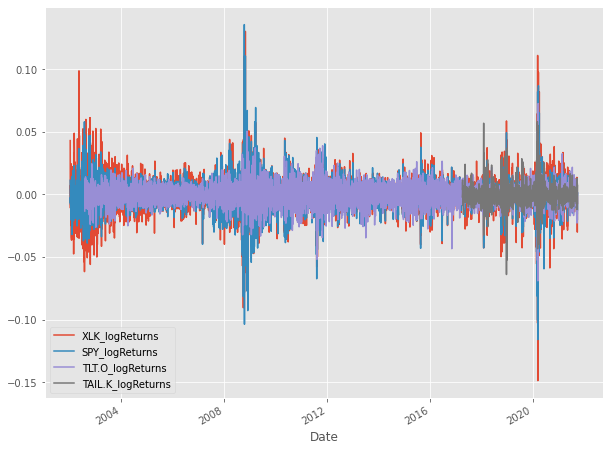

In [35]:
# ploting log-returns
df_features.iloc[:,0:4].plot(figsize=(10,8))
plt.legend(loc='best')
plt.xlabel('Date')
plt.show()

(?) Porque anualizar, e porque usar 13 semanas como janela deslizante?

In [36]:
# 13-week annualized volatility
period = 13
for ticker,ticker_name in zip(df,tickers_list):
    v_logRet = np.log(df[ticker] / df[ticker].shift(1))
    v_volatility = v_logRet.rolling(window=period).std() * np.sqrt(52)
    df_field = ticker_name + '_volatility'
    df_features[df_field] = v_volatility

df_features = df_features.drop(['VIX_volatility'], axis=1)
df_features

,XLK_logReturns,SPY_logReturns,TLT.O_logReturns,TAIL.K_logReturns,XLK_volatility,SPY_volatility,TLT.O_volatility,TAIL.K_volatility
2002-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2002-01-03,0.042966,0.011275,NaN,NaN,NaN,NaN,NaN,NaN
2002-01-04,0.006211,0.006654,NaN,NaN,NaN,NaN,NaN,NaN
2002-01-07,-0.010895,-0.007082,NaN,NaN,NaN,NaN,NaN,NaN
2002-01-08,0.007406,-0.002315,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
2021-09-24,0.000702,0.001646,-0.009822,-0.007275,0.072057,0.061163,0.075470,0.048545
2021-09-27,-0.009747,-0.002865,-0.003682,0.000000,0.073901,0.061242,0.074281,0.047680
2021-09-28,-0.030089,-0.020358,-0.015700,0.008616,0.093219,0.071989,0.074206,0.049630
2021-09-29,-0.001263,0.001682,0.001734,-0.001068,0.092358,0.071510,0.073573,0.049572


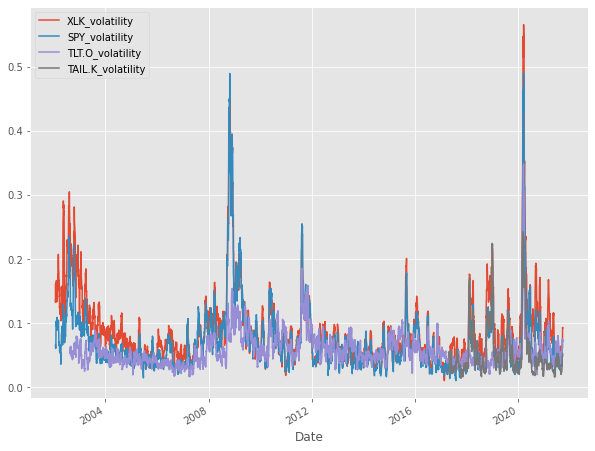

In [37]:
# ploting volatility
df_features.iloc[:,4:8].plot(figsize=(10,8))
plt.legend(loc='best')
plt.xlabel('Date')
plt.show()

In [38]:
# 26-week kurtosis
period = 26
for ticker,ticker_name in zip(df,tickers_list):
    v_logRet = np.log(df[ticker] / df[ticker].shift(1))
    v_kurtosis = v_logRet.rolling(window=period).kurt()
    df_field = ticker_name + '_kurtosis'
    df_features[df_field] = v_kurtosis

#df_features = df_features.drop(['VIX_kurtosis'], axis=1)
df_features

,XLK_logReturns,SPY_logReturns,TLT.O_logReturns,TAIL.K_logReturns,XLK_volatility,SPY_volatility,TLT.O_volatility,TAIL.K_volatility,XLK_kurtosis,SPY_kurtosis,TLT.O_kurtosis,TAIL.K_kurtosis,VIX_kurtosis
2002-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2002-01-03,0.042966,0.011275,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2002-01-04,0.006211,0.006654,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2002-01-07,-0.010895,-0.007082,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2002-01-08,0.007406,-0.002315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-09-24,0.000702,0.001646,-0.009822,-0.007275,0.072057,0.061163,0.075470,0.048545,0.205242,0.480938,0.329589,1.430598,0.250938
2021-09-27,-0.009747,-0.002865,-0.003682,0.000000,0.073901,0.061242,0.074281,0.047680,-0.002640,0.369011,0.442458,1.459553,0.095888
2021-09-28,-0.030089,-0.020358,-0.015700,0.008616,0.093219,0.071989,0.074206,0.049630,1.405971,0.694170,-0.053590,0.752656,0.143128
2021-09-29,-0.001263,0.001682,0.001734,-0.001068,0.092358,0.071510,0.073573,0.049572,1.783174,0.944613,-0.074694,0.864392,0.264703


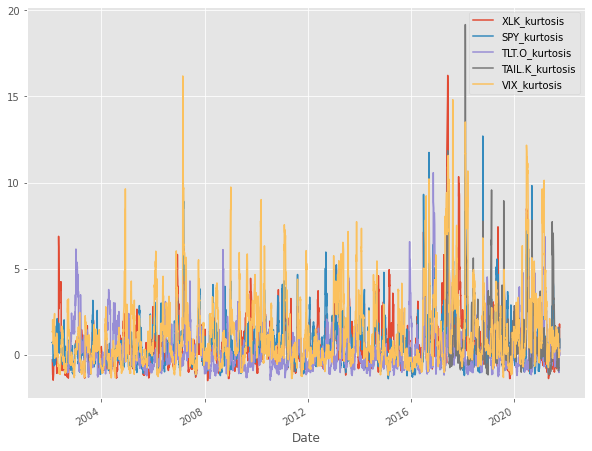

In [39]:
# ploting kurtosis
df_features.iloc[:,8:13].plot(figsize=(10,8))
plt.legend(loc='best')
plt.xlabel('Date')
plt.show()

In [40]:
# inserting VIX into dataframe of features
df_features['VIX'] = df['VIX']
df_features.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4972 entries, 2002-01-02 to 2021-09-30
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   XLK_logReturns     4971 non-null   float64
 1   SPY_logReturns     4971 non-null   float64
 2   TLT.O_logReturns   4829 non-null   float64
 3   TAIL.K_logReturns  1129 non-null   float64
 4   XLK_volatility     4959 non-null   float64
 5   SPY_volatility     4959 non-null   float64
 6   TLT.O_volatility   4817 non-null   float64
 7   TAIL.K_volatility  1117 non-null   float64
 8   XLK_kurtosis       4946 non-null   float64
 9   SPY_kurtosis       4946 non-null   float64
 10  TLT.O_kurtosis     4804 non-null   float64
 11  TAIL.K_kurtosis    1104 non-null   float64
 12  VIX_kurtosis       4946 non-null   float64
 13  VIX                4972 non-null   float64
dtypes: float64(14)
memory usage: 582.7 KB


In [41]:
# 60 days - momentum probabilistic
period = 60 

df_returns = df.pct_change(axis=0)
dateIndex= df_returns.index

# SPY x TAIL
left_ticker = 'SPY'
right_ticker = 'TAIL.K'
column_name = left_ticker + '_' + right_ticker + '_probMomentum' 
for date in dateIndex:
    mom= checkForProbMomentum(df_returns, left_ticker, right_ticker, 
                              date, period)
    df_features.loc[date, column_name] =  mom

# SPY x TLT    
left_ticker = 'SPY'
right_ticker = 'TLT.O'
column_name = left_ticker + '_' + right_ticker + '_probMomentum' 
for date in dateIndex:
    mom= checkForProbMomentum(df_returns, left_ticker, right_ticker, 
                              date, period)
    df_features.loc[date, column_name] =  mom

# SPY x XLK    
left_ticker = 'SPY'
right_ticker = 'XLK'
column_name = left_ticker + '_' + right_ticker + '_probMomentum' 
for date in dateIndex:
    mom= checkForProbMomentum(df_returns, left_ticker, right_ticker, 
                              date, period)
    df_features.loc[date, column_name] =  mom

# XLK x TAIL    
left_ticker = 'XLK'
right_ticker = 'TAIL.K'
column_name = left_ticker + '_' + right_ticker + '_probMomentum' 
for date in dateIndex:
    mom= checkForProbMomentum(df_returns, left_ticker, right_ticker, 
                              date, period)
    df_features.loc[date, column_name] =  mom

# XLK x TLT    
left_ticker = 'XLK'
right_ticker = 'TLT.O'
column_name = left_ticker + '_' + right_ticker + '_probMomentum' 
for date in dateIndex:
    mom= checkForProbMomentum(df_returns, left_ticker, right_ticker, 
                              date, period)
    df_features.loc[date, column_name] =  mom


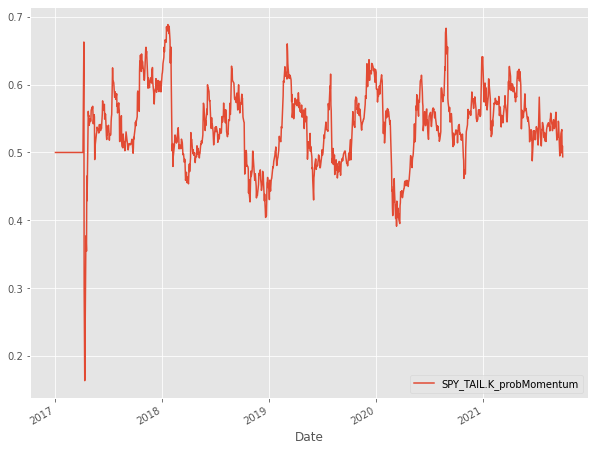

In [42]:
# ploting probabilistc momentum
v_dateFromStr = '2017-01-01'
v_dateToStr = '2021-10-01'
#df_features.loc[v_dateFromStr:v_dateToStr,['SPY_TAIL.K_probMomentum','SPY_TLT.O_probMomentum','SPY_XLK_probMomentum', 'XLK_TAIL.K_probMomentum', 
#                   'XLK_TLT.O_probMomentum']].plot(figsize=(10,8))
df_features.loc[v_dateFromStr:v_dateToStr,'SPY_TAIL.K_probMomentum'].plot(figsize=(10,8))

plt.legend(loc='best')
plt.xlabel('Date')
plt.show()

In [43]:
df_features2 = pd.concat([df_features, df.drop(['VIX'], axis=1).pct_change(axis=0)], axis=1)
df_features2.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4972 entries, 2002-01-02 to 2021-09-30
Data columns (total 23 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   XLK_logReturns           4971 non-null   float64
 1   SPY_logReturns           4971 non-null   float64
 2   TLT.O_logReturns         4829 non-null   float64
 3   TAIL.K_logReturns        1129 non-null   float64
 4   XLK_volatility           4959 non-null   float64
 5   SPY_volatility           4959 non-null   float64
 6   TLT.O_volatility         4817 non-null   float64
 7   TAIL.K_volatility        1117 non-null   float64
 8   XLK_kurtosis             4946 non-null   float64
 9   SPY_kurtosis             4946 non-null   float64
 10  TLT.O_kurtosis           4804 non-null   float64
 11  TAIL.K_kurtosis          1104 non-null   float64
 12  VIX_kurtosis             4946 non-null   float64
 13  VIX                      4972 non-null   float64
 14  SPY_TA

In [29]:
df_features2.head()

,XLK_logReturns,SPY_logReturns,TLT.O_logReturns,TAIL.K_logReturns,XLK_volatility,SPY_volatility,TLT.O_volatility,TAIL.K_volatility,XLK_kurtosis,SPY_kurtosis,...,VIX,SPY_TAIL.K_probMomentum,SPY_TLT.O_probMomentum,SPY_XLK_probMomentum,XLK_TAIL.K_probMomentum,XLK_TLT.O_probMomentum,XLK,SPY,TLT.O,TAIL.K
2002-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,21.5000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2002-01-11,0.003410,-0.005875,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,22.1720,0.5,0.5,0.500000,0.5,0.5,0.003416,-0.005857,NaN,NaN
2002-01-18,-0.036560,-0.018958,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,22.9000,0.5,0.5,0.573523,0.5,0.5,-0.035899,-0.018779,NaN,NaN
2002-01-25,-0.039938,-0.005459,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,21.9125,0.5,0.5,0.715876,0.5,0.5,-0.039151,-0.005444,NaN,NaN
2002-02-01,-0.003696,-0.007222,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,22.1840,0.5,0.5,0.672679,0.5,0.5,-0.003689,-0.007196,NaN,NaN


In [20]:
#df_features2.to_csv(OUTPUT+'.csv', index=True)

In [44]:
df_features.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4972 entries, 2002-01-02 to 2021-09-30
Data columns (total 19 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   XLK_logReturns           4971 non-null   float64
 1   SPY_logReturns           4971 non-null   float64
 2   TLT.O_logReturns         4829 non-null   float64
 3   TAIL.K_logReturns        1129 non-null   float64
 4   XLK_volatility           4959 non-null   float64
 5   SPY_volatility           4959 non-null   float64
 6   TLT.O_volatility         4817 non-null   float64
 7   TAIL.K_volatility        1117 non-null   float64
 8   XLK_kurtosis             4946 non-null   float64
 9   SPY_kurtosis             4946 non-null   float64
 10  TLT.O_kurtosis           4804 non-null   float64
 11  TAIL.K_kurtosis          1104 non-null   float64
 12  VIX_kurtosis             4946 non-null   float64
 13  VIX                      4972 non-null   float64
 14  SPY_TA

In [47]:
df_features.head()

,XLK_logReturns,SPY_logReturns,TLT.O_logReturns,TAIL.K_logReturns,XLK_volatility,SPY_volatility,TLT.O_volatility,TAIL.K_volatility,XLK_kurtosis,SPY_kurtosis,TLT.O_kurtosis,TAIL.K_kurtosis,VIX_kurtosis,VIX,SPY_TAIL.K_probMomentum,SPY_TLT.O_probMomentum,SPY_XLK_probMomentum,XLK_TAIL.K_probMomentum,XLK_TLT.O_probMomentum
2002-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22.709999,NaN,NaN,NaN,NaN,NaN
2002-01-03,0.042966,0.011275,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21.340000,0.5,0.5,0.500000,0.5,0.5
2002-01-04,0.006211,0.006654,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.450001,0.5,0.5,0.281258,0.5,0.5
2002-01-07,-0.010895,-0.007082,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21.940001,0.5,0.5,0.335137,0.5,0.5
2002-01-08,0.007406,-0.002315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21.830000,0.5,0.5,0.296378,0.5,0.5


In [48]:
df_features.to_csv(OUTPUT+'.csv', index=True)

In [24]:
df_features2.shape

(1031, 23)

In [86]:
import torch

In [88]:
torch.tensor(0).item()

0